# Import PhiFlow

In [5]:
#from phi.flow import *
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid
# Helper functions for visualization
from src.visu import *

import time

# Initialization Functions

In [21]:
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 20
# Number of basis fields
N = 5**2

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 23.09849500656128 seconds


In [10]:
def init_smoke():
    smoke = CenteredGrid(
        Box(x=[1,2], y=[1,2]), 
        extrapolation.BOUNDARY, 
        x=100, y=100, 
        bounds=DOMAIN
    )
    return smoke

# Visualize Some Basis Fields

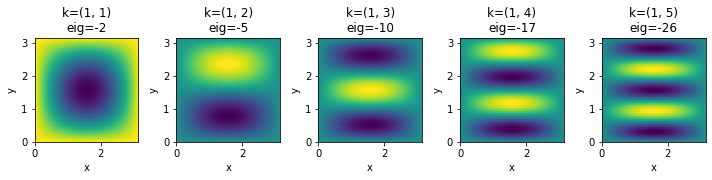

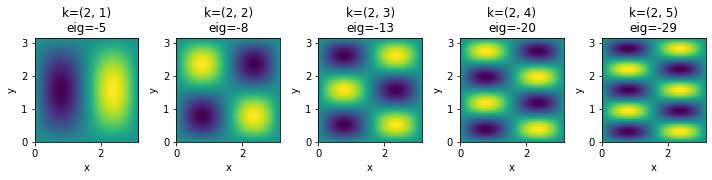

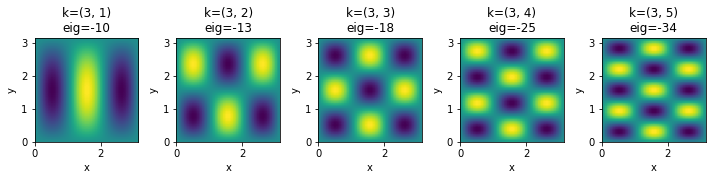

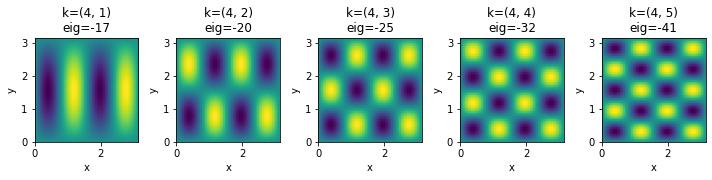

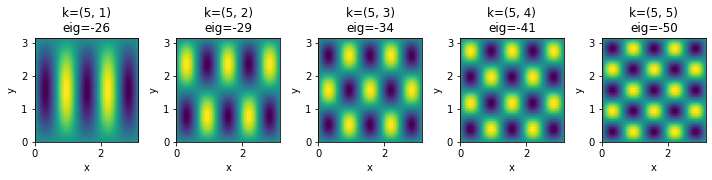

In [71]:
eigenfluid.SAMPLING_SIZE = 40

curls = []
curls_title = []

# Visualize individual velocity fields
for k in range(N):
    eigenfluid.w = tensor([1.0 if i == k else 0. for i in range(N)], eigenfluid.w.shape)
    velocity = eigenfluid.reconstruct_velocity()
    
    curls_title.append("k=({}, {})\neig={}".format(*eigenfluid.basis_fields.i[k]))
    curls.append(field.curl(velocity))

# Plot curls in NxN layout
# Note: scale is different for each plot
N_sqrt = int(math.sqrt(N))
for row in range(N_sqrt):
    plot(
        {curls_title[i]: curls[i] for i in range(N_sqrt*row, N_sqrt*row+N_sqrt)}, 
        same_scale=False,
        show_color_bar=False,
        size=(10,10)
    )

## Simulate Random Particles in Eigenfluid

In [80]:
N_p = 1000
# Scatter N_p points in the domain
p = math.random_uniform(instance(i=N_p) & channel(vector='x,y'), low=0.0, high=math.PI)
p_velocities = eigenfluid.get_phi_at(p)

trajectory_p = [p]
trajectory_v = [eigenfluid.reconstruct_velocity()]

STEPS = 256
DT = 0.05
VISCOSITY = 0.0

# Initialize basis coefficients w
eigenfluid.w = tensor([1.0 if i == 14 else 0. for i in range(N)], eigenfluid.w.shape)

for i in range(STEPS-1):
    # Step velocity
    eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT, viscosity=VISCOSITY)
    # Get velocities at new positions
    p_velocities = eigenfluid.get_phi_at(p)
    # Midpoint
    p_velocities = eigenfluid.get_phi_at(p + p_velocities*DT/2)
    # Euler step for points
    p += p_velocities * DT
    # Save trajectory
    trajectory_p.append(p)
    curr_vel = eigenfluid.reconstruct_velocity()
    trajectory_v.append(curr_vel)

trajectory_p = math.stack(trajectory_p, batch('time'))
trajectory_v = math.stack(trajectory_v, batch('time'))

vis.plot(vis.overlay(
            PointCloud(trajectory_p, bounds=DOMAIN, color="black"),
            #trajectory_v
        ),
        animate='time',
        same_scale=False,
        size=(4,4),
        frame_time = 10
)

<Figure size 432x288 with 0 Axes>

# Comparison with Traiditional Fluid Simulation

## Run Fluid Simulation

In [11]:
w = init_w(random=True)/N
print(w.native())
velocity = reconstruct_velocity()
smoke = init_smoke()

trajectory_v = [velocity]
trajectory_curl = [field.curl(velocity)]
trajectory_smoke = [smoke]

start_time = time.time()

for i in range(99):
    velocity = advect.semi_lagrangian(velocity, velocity, dt=0.1)
    velocity, _ = fluid.make_incompressible(velocity)
    smoke = advect.mac_cormack(smoke, velocity, dt=0.1)

    trajectory_v.append(velocity)
    trajectory_curl.append(field.curl(velocity))
    trajectory_smoke.append(smoke)
    
    
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

trajectory_v = math.stack(trajectory_v, batch('time'))
trajectory_curl = math.stack(trajectory_curl, batch('time'))
trajectory_smoke = math.stack(trajectory_smoke, batch('time'))

tensor([ 0.0771,  0.0595,  0.0360, -0.0842,  0.0271, -0.0494, -0.0017, -0.0642,
        -0.0301, -0.0275, -0.0197,  0.0097, -0.0444,  0.0037, -0.0927, -0.0087,
        -0.0554, -0.0158,  0.0321, -0.0249, -0.0237, -0.0025, -0.0331,  0.0132,
        -0.0623])
Simulation finished in 26.836983919143677 seconds


## Plot Results of Traditional Fluid Simulation

In [12]:
vis.plot([trajectory_smoke, trajectory_v, trajectory_curl], animate='time', same_scale=False)

<Figure size 640x480 with 0 Axes>